In [153]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [154]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\AUDEPIN\\.keras\\datasets\\auto-mpg.data'

In [155]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()
#print(dataset)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [156]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [157]:
dataset = dataset.dropna()

In [158]:
origin = dataset.pop('Origin')

In [159]:
dataset['USA'] = ( origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

In [160]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [161]:
trainData=dataset.sample(frac = 0.8, random_state = 0)
testData = dataset.drop(trainData.index)

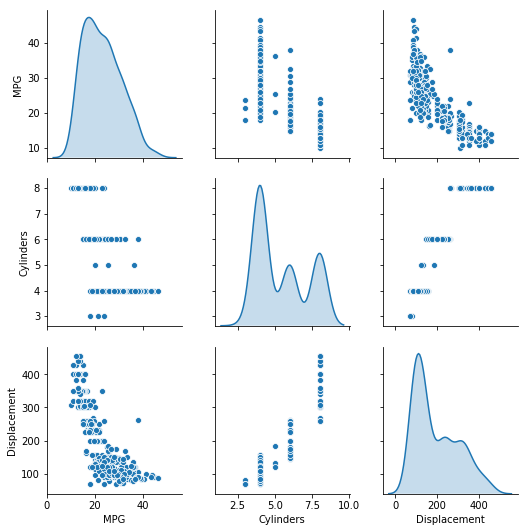

In [162]:
sns.pairplot(trainData[['MPG','Cylinders','Displacement']],diag_kind="kde")

In [163]:
train_stats = trainData.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [164]:
train_labels = trainData.pop('MPG')
test_labels = testData.pop('MPG')

In [165]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(trainData)
normed_test_data = norm(testData)

In [166]:
model = keras.Sequential([
    layers.Dense(64, activation= tf.nn.relu, input_shape = [len(trainData.keys())]),
    layers.Dense(64),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)



model.compile(loss = 'mean_squared_error',
             optimizer=optimizer,
             metrics=['mean_absolute_error', 'mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [167]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
#  callbacks=[PrintDot()]
    
EPOCHS = 1000

stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,callbacks=[stop, PrintDot()])


..............................................................

In [168]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
57,6.608861,1.825943,6.608861,8.875310,2.330262,8.875310,57
58,6.691654,1.853801,6.691654,8.493265,2.271418,8.493265,58
59,6.639182,1.826272,6.639182,8.825789,2.231419,8.825789,59
60,6.967019,1.870563,6.967019,8.530645,2.250479,8.530645,60
61,6.659963,1.813111,6.659964,8.791910,2.234271,8.791910,61


dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


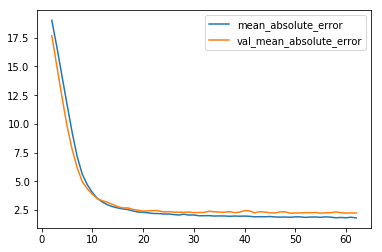

In [169]:
print(history.history.keys())

plotlist=[]
plotname=[ 'mean_absolute_error',
          'val_mean_absolute_error']

for name in plotname:
    plotlist.append(history.history[name])

epoch = range(1, len(plotlist[0])+1)
    
for i in range(len(plotlist)):
    plt.plot(epoch[1:], plotlist[i][1:],label=plotname[i])

plt.legend()
plt.show()

In [170]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.88 MPG


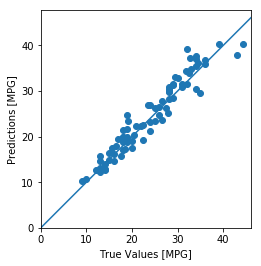

In [171]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])